Group Member: Xiaoyan HONG, Xincheng LUO, and Joshua FAN

In [ ]:
# Tutorial
# https://minihack.readthedocs.io/en/latest/tutorials/des_file_tutorial.html

# Initialize the environment

In [1]:
!sudo apt-get install -y build-essential autoconf libtool pkg-config \
    python3-dev python3-pip python3-numpy git libncurses5-dev \
    libzmq3-dev flex bison
!git clone https://github.com/google/flatbuffers.git
!cd flatbuffers && cmake -G "Unix Makefiles" && make -j2 && sudo make install
!pip install cmake==3.15.3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11.1).
autoconf set to manually installed.
libncurses5-dev is already the newest version (6.2-0ubuntu2).
pkg-config is already the newest version (0.29.1-0ubuntu4).
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
libzmq3-dev is already the newest version (4.3.2-2ubuntu1).
build-essential is already the newest version (12.8ubuntu1.1).
git is already the newest version (1:2.25.1-1ubuntu3.10).
The following additional packages will be installed:
  libfl-dev libfl2 python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  bison-doc flex-doc libtool-doc gcj-jdk python-numpy-doc python3-pytest
  python3-numpy-dbg python-setuptools-doc
The following NEW packages will be installed:
  bison flex libfl-dev libfl2 libtool python-pip-whl python3-numpy python3-pip
  python3-setuptools python3-wheel

In [2]:
!pip install pip==21.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [3]:
! pip install minihack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 227 kB 8.7 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 624 kB 46.3 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 7.0 MB 51.1 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for minihack: filename=minihack-0.1.5-py3-none-any.whl size=265186 sha256=dcd33e6beabdab71c56ea810c685bf88c3238d993ee3588b696008605eb1099b
  Stored in directory: /root/.cache

In [4]:
# The original library has a bug, we have suggested the author to fix it, but not updated to pip yet
from minihack.tiles.rendering import get_des_file_rendering
# Copyright (c) Facebook, Inc. and its affiliates.

from minihack import MiniHackSkill
from nle.nethack.actions import MiscDirection
import PIL.Image
import PIL.ImageChops
import math


def get_image(pixel_obs, full_screen=False, resize=None, relative=False):
    image = PIL.Image.fromarray(pixel_obs)
    if not full_screen:
        bg = PIL.Image.new(image.mode, image.size, image.getpixel((0, 0)))
        diff = PIL.ImageChops.difference(image, bg)
        diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
        bbox = diff.getbbox()
        if bbox:
            image = image.crop(bbox)

    if resize is not None:
        x_resize, y_resize = resize
        if relative:
            image = image.resize(
                (int(image.width * x_resize), int(image.height * y_resize))
            )
        else:
            image = image.resize((x_resize, y_resize))

    return image


def get_des_file_rendering(
    des_file,
    n_images=1,
    full_screen=False,
    full_obs=True,
    resize=None,
    relative=True,
    wizard=False,
):
    class MHCustom(MiniHackSkill):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, des_file=des_file, **kwargs)

    def get_pixel_obs(env, full_obs=True):
        obs = env.reset()
        if full_obs and wizard:
            for c in (
                "#wizintrinsic\rt\r\r#wizmap\r#wizwish\r"
                + "a potion of object detection\r"
            ):
                obs, sds = env.env.step(ord(c))
            msg = (
                obs[env._original_observation_keys.index("message")]
                .tobytes()
                .decode("utf-8")
            )

            for c in f"q{msg[0]}":
                obs, sds = env.env.step(ord(c))

            obs, _, _, _ = env.step(env._actions.index(MiscDirection.WAIT))
        return obs

    env = MHCustom(
        savedir=None,
        observation_keys=("pixel",),
        wizard=wizard,
    )
    if n_images == 1:
        obs = get_pixel_obs(env, full_obs=full_obs)
        image = get_image(
            obs["pixel"],
            full_screen=full_screen,
            resize=resize,
            relative=relative,
        )
        return image
    else:
        images = []
        for _i in range(n_images):
            obs = get_pixel_obs(env, full_obs=full_obs)
            images.append(
                get_image(
                    obs["pixel"],
                    resize=resize,
                    relative=relative,
                    full_screen=full_screen,
                )
            )
        width = images[0].width
        height = images[0].height
        result = PIL.Image.new(
            "RGB",
            ((width * 3) + 10, ((height + 5) * math.ceil(n_images / 3)) - 5),
            color=(200, 200, 200),
        )
        for j in range(math.ceil(n_images / 3)):
            for i in range(3):
                try:
                    result.paste(
                        images[(j * 3) + i],
                        ((width + 5) * i, (height + 5) * j),
                    )
                except IndexError:
                    return result
        return result

# Explore the environment

Tutorial: https://minihack.readthedocs.io/en/latest/tutorials/des_file_tutorial.html

In [ ]:
import IPython.display
def render_des_file(des_file, **kwargs):
    image = get_des_file_rendering(des_file, **kwargs)
    IPython.display.display(image)

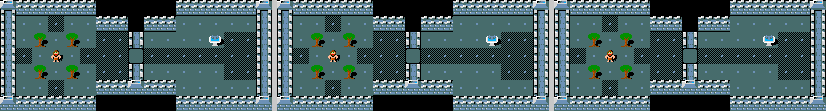

In [ ]:
# Maze type
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
|-----     ------
|.....-- --.....|
|.T.T...-....K..|
|.......+.......|
|.T.T...-.......|
|.....-----.....|
|-----     ------
ENDMAP
BRANCH: (3,3,3,3),(4,4,4,4)
"""
render_des_file(des_file, n_images=3, full_screen=False)

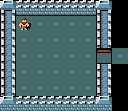

In [ ]:
des_file = """
MAZE: "mylevel",' '
GEOMETRY:center,center
MAP
-------------
|.....|.....|
|.....|.....|
|.....+.....|
|.....|.....|
|.....|.....|
-------------
ENDMAP
REGION:(0,0,12,6),lit,"ordinary"
BRANCH:(1,1,6,6),(0,0,0,0) 
DOOR:locked,(6,3)
STAIR:(8,3),down
"""
render_des_file(des_file, n_images=1, full_screen=False)

MAZE: "mylevel",' '：定义了一个名为 mylevel 的迷宫，并将墙壁字符设置为空格。

GEOMETRY:center,center：将迷宫在屏幕中央居中。
MAP：开始定义迷宫的地图布局。

```
-------------：定义迷宫地图的顶部和底部墙壁。
|.....|.....|：定义两个房间，用中央的竖线进行分隔，每个房间中间有一扇门。
|.....|.....|
|.....+.....|：定义连接两个房间的门，中心位置用 + 表示。
|.....|.....|：与第4行相同。
|.....|.....|
-------------：定义迷宫地图的顶部和底部墙壁。
```
ENDMAP：结束地图布局的定义。

REGION:(0,0,12,6),lit,"ordinary"：定义区域 (0,0)-(12,6)，使其在探索时始终可见（lit指照明状态），并将其标记为 "ordinary" 类型的区域。

BRANCH:(1,1,6,6),(0,0,0,0)：定义一个分支，其中 (1,1) 表示生成代理的位置，而 (6,6) 表示分支的另一端位置，即两个对角点确定一个区域。 (0,0,0,0) 表示此分支中代理不能访问的任何位置。

DOOR:locked,(6,3)：在 (6,3) 处创建一扇锁定的门，必须使用合适的钥匙才能打开。

STAIR:(8,3),down：在 (8,3) 处创建一个向下的楼梯，代理可以使用它进入下一个地下层。

Components(wall, corridor, etc.): https://nethackwiki.com/wiki/Des-file_format#Map_characters


```
Terrains = [
    " ",  # solid wall
    "#",  # corridor
    ".",  # room floor (Unlit, unless lit with REGION-command)
    "-",  # horizontal wall
    "|",  # vertical wall
    "+",  # door (State is defined with DOOR -command)
    "A",  # air
    "B",  # crosswall / boundary symbol hack (See REGION)
    "C",  # cloud
    "S",  # secret door
    "H",  # secret corridor
    "{",  # fountain
    "\\", # throne
    "K",  # sink
    "}",  # moat
    "P",  # pool of water
    "L",  # lava pool
    "I",  # ice
    "W",  # water
    "T",  # tree
    "F",  # iron bars
]
```



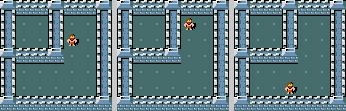

In [ ]:
# Room type
des_file = """  
LEVEL: "mylevel"
FLAGS: premapped

ROOM: "ordinary" , lit, (3,3), (center,center), (5,5) {
    SUBROOM: "ordinary", lit, (0,0), (2,2) {
    }
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3, full_screen=False)

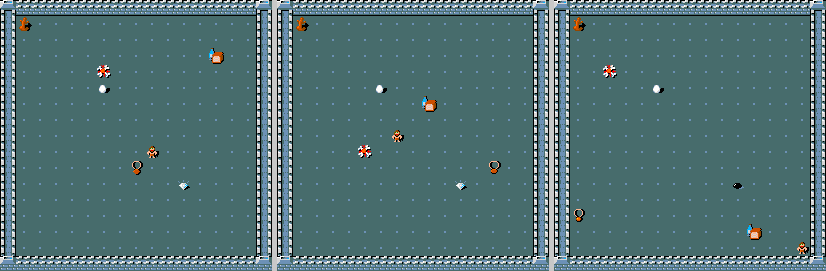

In [ ]:
# Monsters
des_file = """
LEVEL: "mylevel"
FLAGS: premapped
REGION: (0,0,20,80), lit, "ordinary"

ROOM: "ordinary", lit, random, (center,center), (15,15) {
    OBJECT:('%', "food ration"), random
    OBJECT:'*', (10,10)
    OBJECT :('"', "amulet of life saving"), random
    OBJECT:('%', "corpse"), random
    OBJECT:('`', "statue"), (0,0), montype:"forest centaur", 1
    OBJECT:('(', "crystal ball"), (17,08), blessed, 5,name:"The Orb of Fate"
    OBJECT:('%',"egg"), (05,04), montype:"yellow dragon"
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

# Build the evironment

In [5]:
import numpy as np
from minihack import MiniHackNavigation
from minihack import LevelGenerator
from minihack import RewardManager
import random as rd
import gym
import matplotlib.pyplot as plt

- Add customized reward function to adapt to the navigation task

In [6]:
# Intuition: make the reward function denser, so that the agent can learn how to reach the target quicker.
def reward_check(state,target_pos,size):
    x,y = state
    x1,y1 = target_pos
    # For size*size map
    distance = np.sqrt((x-x1)**2+(y-y1)**2)
    max_distance = np.sqrt(size**2+size**2)
    score = - distance/max_distance
    # The closer the agent is with to the target, the larger the score
    # Add extra bonus when agent reach certain area closer enough to the target, so that the agent won't go back easily
    if distance < 0.85 * max_distance:
        return score+ 0.05
    elif distance < 0.7 * max_distance:
        return score+ 0.1
    elif distance < 0.6 * max_distance :
        return score+ 0.2
    elif distance < 0.5 * max_distance :
        return score+ 0.3
    elif distance < 0.33 * max_distance:
        return score+ 0.5
    elif distance < 0.25 * max_distance:
        return score+ 0.7
    elif distance < 0.15 * max_distance:
        return score+ 0.99
    else:
        return score

In [7]:
class MiniHackRoom(MiniHackNavigation):
    """Customized environment"""
    def __init__(
        self,
        *args,
        size=5,
        n_monster=0,
        n_trap=0,
        n_teleport=0,
        lit=True,
        level=1,
        fixend=None,
        **kwargs
    ):
        kwargs["max_episode_steps"] = kwargs.pop(
            "max_episode_steps", size * 200
        )

        lvl_gen = LevelGenerator(w=size, h=size, lit=lit)
        self.x_start = 0
        self.y_start = 0

        self.x_target = size-1 if fixend is not None else rd.randint(0, size-1)
        self.y_target = size-1 if fixend is not None else rd.randint(0, size-1)
        lvl_gen.add_goal_pos((self.x_target, self.y_target))
        lvl_gen.set_start_pos((self.x_start, self.y_start))

        # Add some trees
        if level == 1:
            lvl_gen.fill_terrain("rect", "T", 5, 5, 9, 9)
        elif level == 2:
            lvl_gen.fill_terrain("rect", "T", 0, 5, 3, 5)
            lvl_gen.fill_terrain("rect", "T", 9, 10, 14, 10) 
        elif level == 3:
            lvl_gen.fill_terrain("rect", "T", 12, 2, 13, 6)
            lvl_gen.fill_terrain("rect", "T", 1, 15, 6, 16)

        # Add monster
        for _ in range(n_monster):
            lvl_gen.add_monster('hobbit',args=["peaceful"])

        # Sink
        for _ in range(n_trap):
            lvl_gen.add_sink()

        # Add Teleport
        for _ in range(n_teleport):
            lvl_gen.add_trap('teleport')
        
        # Add extra harmful objects
        if level == 3:
            lvl_gen.add_object("axe", ")",(12,10))
            lvl_gen.add_object("apple", "%",(10,17))
            lvl_gen.fill_terrain("rect",'P', 0,5,4,8) 
            lvl_gen.fill_terrain("rect",'P', 14,9,19,11)

        # Define a reward manager
        reward_manager = RewardManager()
        if level == 3:
            adj_x, adj_y = 30,1
        else:
            adj_x, adj_y = 32,3

        # -2 reward for standing on a sink
        if level == 2:
            reward_manager.add_location_event("sink", reward=-2, terminal_required=False)
        elif level == 3:
            reward_manager.add_location_event("sink", reward=-2, terminal_required=False)
            reward_manager.add_location_event('axe', reward=-3, terminal_required=False,repeatable=True)
            reward_manager.add_location_event("apple",reward=-2, terminal_required=False,repeatable=True)
        reward_manager.add_coordinate_event((self.x_target+adj_x, self.y_target+adj_y), reward=20, terminal_required=True,terminal_sufficient=True)
        
        for i in range(size):
            for j in range(size):
                rewardcustom = reward_check((i,j),(self.x_target, self.y_target),size)
                reward_manager.add_coordinate_event((i+adj_x,j+adj_y), reward = rewardcustom, repeatable=True, terminal_required=False)

        super().__init__(*args, des_file=lvl_gen.get_des(), reward_manager=reward_manager, **kwargs)

class MiniHackRoom15x15L1(MiniHackRoom):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, size = 15, fixend = True, n_monster=0, n_trap=0, n_teleport=0, level = 1, **kwargs)

class MiniHackRoom15x15L2(MiniHackRoom):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, size = 15, fixend = True, n_monster=1, n_trap=1, n_teleport=1, level = 2, **kwargs)

class MiniHackRoom20x20L3(MiniHackRoom):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, size = 20, n_monster=2, n_trap=2, n_teleport=2, level = 3, **kwargs)


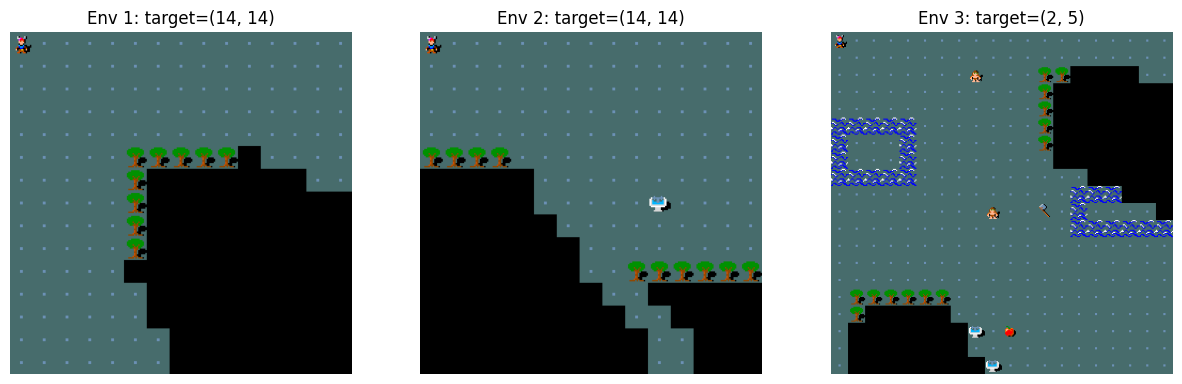

In [8]:
env1 = MiniHackRoom15x15L1(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 
env2 = MiniHackRoom15x15L2(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 
env3 = MiniHackRoom20x20L3(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Visualize the initial environment for env1
state1 = env1.reset()
axes[0].imshow(get_image(state1['pixel']))
axes[0].set_title('Env 1: target={}'.format((env1.x_target, env1.y_target)))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].axis('off')

# Visualize the initial environment for env2
state2 = env2.reset()
axes[1].imshow(get_image(state2['pixel']))
axes[1].set_title('Env 2: target={}'.format((env2.x_target, env2.y_target)))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].axis('off')

# Visualize the initial environment for env3
state3 = env3.reset()
axes[2].imshow(get_image(state3['pixel']))
axes[2].set_title('Env 3: target={}'.format((env3.x_target, env3.y_target)))
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].axis('off')

plt.show()


The current coordinates are: [ 4 32]
The current reward is: -1.0333333333333334


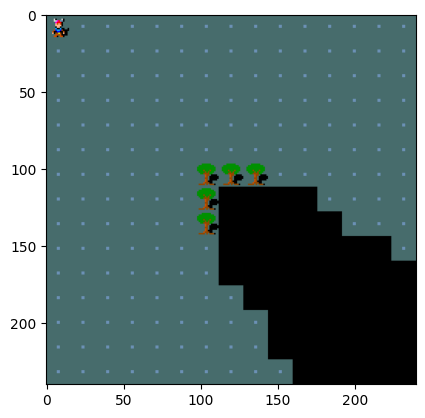

In [ ]:
# Try to walk by hand, for example 
env = env1
# 0: up, 1: right, 2: down, 3: left, 4: up right, 5: down right, 6: down left, 7: up left
state, reward, done, info = env.step(7) 
print("The current coordinates are:",state['tty_cursor'])
print("The current reward is:",reward)

next_state_image = get_image(state['pixel'])
plt.imshow(next_state_image)

# Build Agent

In [10]:
from abc import ABC, abstractmethod
from typing import Any

from os.path import split, exists
from os import makedirs

from typing import List
import numpy as np

import sys
import gym

# Define a default class for later use
class Agent(ABC):

    def __init__(self):
        try:
            # The decode_state function is to make the state into an immutable format(not necessary if we preprocessed.)
            self.decode_state(1)
        except NotImplementedError:
            print("Please implement the static method 'decode_state' before procedding.")
            exit(-1)
        except:
            pass

    def save(self, path):
        dir = split(path)[0]
        if dir == '':
            dir = '.'
        if not exists(dir):
            makedirs(dir)

Common functions

In [11]:
# Plot the model performance
def plot_performance(rewards,level):
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Sum of rewards\n during\n episode",rotation=0, labelpad=40)
    plt.title("Level "+level)
    plt.legend()
    plt.show()

In [12]:
# Visualize the playing process (live!)
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

def live_play_viz(env, agent):
    state = env.reset()
    n = 0
    done = False
    plt.figure(1)
    while not done:
        n += 1
        action = agent.take_action(state)
        state, reward, done, info = env.step(action)
        agent.update(state, reward)
        
        plt.imshow(get_image(state['pixel']))

        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

        plt.pause(0.01)
        plt.clf()

        display.display(plt.gcf())
        display.clear_output(wait=True)

def live_play_viz_es(env, agent):
    state = env.reset()
    n = 0
    done = False
    plt.figure(1)
    while not done:
        n += 1
        action = agent.take_action(state)
        state, reward, done, info = env.step(action)
        agent.update(reward)
        
        plt.imshow(get_image(state['pixel']))

        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

        plt.pause(0.01)
        plt.clf()

        display.display(plt.gcf())
        display.clear_output(wait=True)


In [13]:
# Plot the q value table
def extract_values(dictionary):
    x_values = [key[0][0] for key in dictionary.keys()]
    y_values = [key[0][1] for key in dictionary.keys()]
    z_values = list(dictionary.values())
    return x_values, y_values, z_values

def plot_SVfunction(agent,algoname):
    q_policy_values = agent.q

    x_list, y_list, z_list = extract_values(q_policy_values)

    fig, ax = plt.subplots(ncols=1, figsize=(5, 5), subplot_kw={'projection': '3d'})

    ax.plot_trisurf(x_list, y_list, z_list, cmap='Blues')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title(algoname)

    plt.show()


## Q-learning

In [ ]:
# Define the q learning agent class
class QLearning(Agent):
    def __init__(self, actions: List, alpha: float, gamma: float, eps: float):
        super().__init__()

        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.rand_generator = np.random.RandomState(42)
        # Initialize a q value dictionary
        self.q = {}
        self.prev_state = None
        self.prev_action = None

    def _argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)
        # If we use the argmax function defined by numpy, the index will always be the same
        return self.rand_generator.choice(ties)
    
    def _action_value(self, state, action):
        """ Compute state-action value of this pair."""
        return self.q.get((state, action), 1e-2*np.random.randn())

    def _get_action(self, state, eps):
        """ Return an eps-greedy action to be taken from this state."""
        if np.random.rand() < eps:
            return np.random.choice(self.actions)
        q_values = [self._action_value(state=state, action=action) for action in self.actions]
        action = self._argmax(q_values)
        return action

    def update(self, state, reward):
        """ Update state-action value of previous (state, action).
        Args:
            state (Any): The new state representation. Here we use the coordinate of the agent on the map.
            reward (float): Reward received upon the transaction to `state`.
        Note:
            - The parameter ``state`` should be an immutable type since it's used as a key.
        """
        state = self.decode_state(state)
        q = self._action_value(state=self.prev_state, action=self.prev_action)
        self.q[(self.prev_state, self.prev_action)] = q + self.alpha * \
            (reward - q + self.gamma * self._action_value(state, self._get_action(state, 0)))

    def take_action(self, state):
        """ Choose an eps-greedy action to be taken from this state. 
        Args:
            state (Any): The current state representation. It should be an immutable type since it's used as a key.
        """
        state = self.decode_state(state)
        action = self._get_action(state, self.eps)
        
        self.prev_action = action
        self.prev_state = state
        return action

    def save(self, path: str):
        """ Save state-action value table in `path`.npy
        Args:
            path (str): The location of where to store the state-action value table.
        """
        super().save(path)
        np.save(path + '.npy', self.q)

    def load(self, path):
        """ Load state-action value table.
        If it doesn't exist, a randomly-initialized table is used.
        Args:
            path (str): The location of where the state-action value table resides.
        """

        try:
            self.q = np.load(path + '.npy', allow_pickle='TRUE').item()
        except:
            self.q = {}
            print("No file is found in:", path)

In [ ]:
# Define the function to test q learning agent
def test_minihack_qlearning(env,level):
    ALPHA = 0.1 # Learning rate
    GAMMA = 1 # discount
    EPS = 0.05 # exploration rate, the empirical value from the individual assignment
    ITERS = 200

    class MyAgent(QLearning):
        def decode_state(self, state):
            return tuple(state['tty_cursor'])  

    qlearner = MyAgent(actions=list(range(env.action_space.n)),
                       alpha=ALPHA, gamma=GAMMA, eps=EPS)
    qlearner.load('qlearner_minihack'+level)

    all_rewards = []
    for i in range(ITERS):
        state = env.reset()
        # Get the target postision(Here we fixed it at the bottom right)
        n = 0
        done = False
        rewards = 0
        while not done:
            n += 1
            action = qlearner.take_action(state)
            state, reward, done, info = env.step(action)
            rewards+=reward
            qlearner.update(state, reward)

        qlearner.save('qlearner_minihack'+level)
        all_rewards.append(rewards)
        print('>'*40, f'Episode {i+1} is finished in {n} steps, the reward is {rewards}')

    return qlearner,all_rewards


In [ ]:
env1 = MiniHackRoom15x15L1(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 
env2 = MiniHackRoom15x15L2(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 
env3 = MiniHackRoom20x20L3(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 

In [ ]:
qlearning_agent_L1, all_rewards_L1 = test_minihack_qlearning(env1,"_L1")

In [ ]:
qlearning_agent_L2, all_rewards_L2 = test_minihack_qlearning(env2,"L2")

In [ ]:
qlearning_agent_L3, all_rewards_L3 = test_minihack_qlearning(env3,"L3")

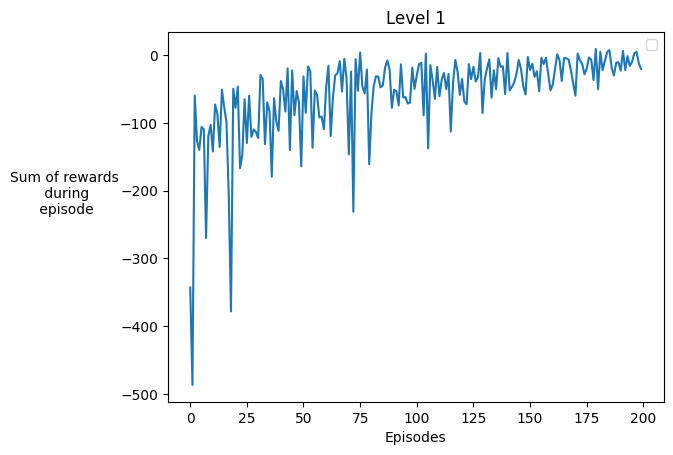

In [ ]:
plot_performance(all_rewards_L1,'1')

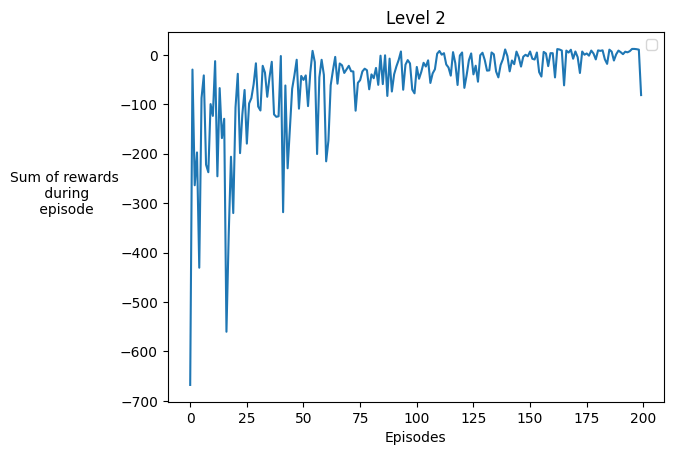

In [ ]:
plot_performance(all_rewards_L2,'2')

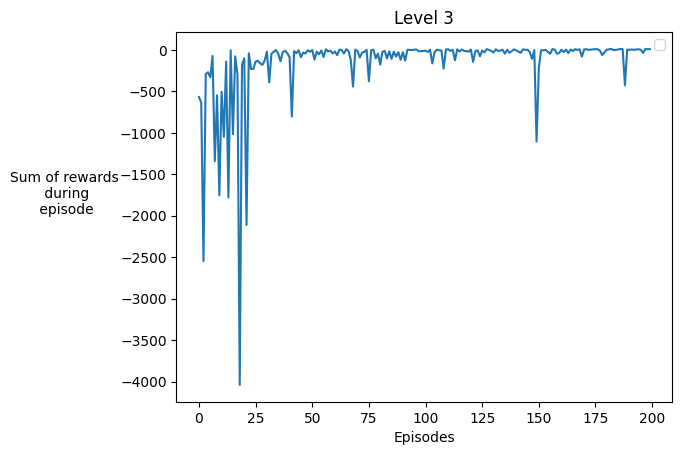

In [ ]:
plot_performance(all_rewards_L3,'3')

In [ ]:
live_play_viz(env1, qlearning_agent_L1)

<Figure size 640x480 with 0 Axes>

In [ ]:
live_play_viz(env2, qlearning_agent_L2)

<Figure size 640x480 with 0 Axes>

In [ ]:
live_play_viz(env3, qlearning_agent_L3)

<Figure size 640x480 with 0 Axes>

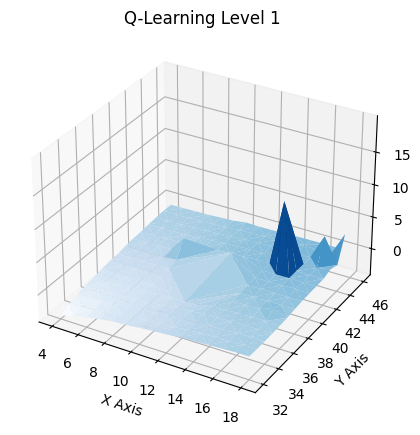

In [ ]:
plot_SVfunction(qlearning_agent_L1,"Q-Learning Level 1")

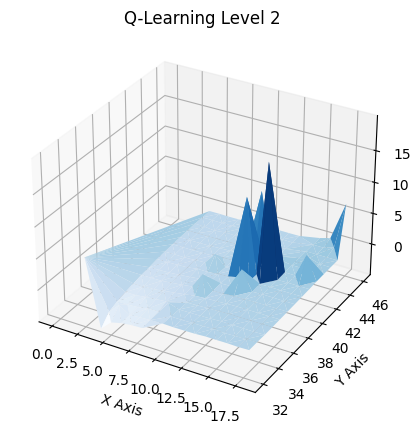

In [ ]:
plot_SVfunction(qlearning_agent_L2,"Q-Learning Level 2")

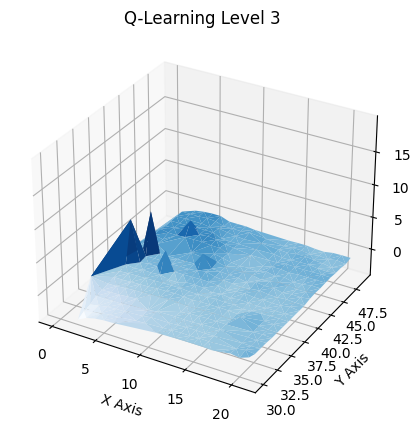

In [ ]:
plot_SVfunction(qlearning_agent_L3,"Q-Learning Level 3")

## DQN

### Simple Architecture

https://github.com/the-beee/RL-algorithms/blob/main/rl_algorithms/qlearning/DQN.py

In [9]:
import collections
from copy import deepcopy
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import List

In [15]:
class DQN(Agent):

    def __init__(self, network: nn.Module, actions: List, alpha: float, gamma: float, eps: float, c: int = 128, t: int = 1024, capacity: int = 1024, bs: int = 32, device='cpu'):
        super().__init__()

        self.actions = {i: action for i, action in enumerate(actions)}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

        self.bs = bs
        self.c = c
        self.t = t

        self.device = device

        self.buffer = ExperienceReplay(capacity, device)
        self.Q = network.to(device)
        self.Q_prime = deepcopy(self.Q).to(device).eval()

        self.loss = nn.MSELoss()
        self.opt = torch.optim.AdamW(self.Q.parameters(), lr=self.alpha)
        self.i = 0  # counter used to trigger the update of Q_prime with Q

        self.prev_state = None
        self.prev_action = None

    def _action_value(self, state, action=None, clone: bool = False):
        """ If clone is False, the `self.Q` network is used, otherwise, `self.Q_prime` is used. """
        Q = self.Q if not clone else self.Q_prime
        n = state.shape[0]
        state = state.to(self.device)
        if action is not None:
            value = Q(state)[list(range(n)), action]
        else:
            value = Q(state)
        return value

    def _get_action(self, state, eps):
        """ Return an eps-greedy action to be taken from this state.    """
        with torch.no_grad():
            if np.random.rand() < eps:  
                return torch.from_numpy(np.random.choice(list(self.actions.keys()), size=(state.shape[0],)))
            actions = self._action_value(state=state, clone=True).argmax(dim=1)
            return actions

    def update(self, state:torch.Tensor, reward:float):
        """ Update state-action value of previous (state, action).
        Args:
            state (Any): The new state representation.
            reward (float): Reward received upon the transaction to `state`.
        Note:
            - The parameter ``state`` should be a tensor with the leading batch dimension.
        """
        state = self.decode_state(state).cpu()

        # register history
        self.buffer.append((self.prev_state, self.prev_action, torch.tensor(reward).unsqueeze(0).float(), state))

        # sample batch_size
        states, actions, rewards, next_states = self.buffer.sample(self.bs)
        gt = rewards + self.gamma * self._action_value(next_states, clone=True).max(dim=1)[0]
        pred = self._action_value(states, actions, clone=False)
        loss = self.loss(pred, gt)

        # update Q
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        if self.i == self.c:
            # update Q_prim
            self.i = 0
            self.Q_prime = deepcopy(self.Q).eval()
        self.i += 1

        try:
            return loss.item()
        except:
            return None

    def take_action(self, state):
        """ Choose an eps-greedy action to be taken from this state. 
        Args:
            state (Any): The current state representation. After fed to ``decode_state``, the output should be eligible to be a network input.
        """
        state = self.decode_state(state)
        assert state.shape[0] == 1
        
        action = self._get_action(state, self.eps).cpu()
        
        self.prev_action = action
        self.prev_state = state
        return self.actions[action.item()]

    def save(self, path: str):
        """ Save state-action value table in `path`.npy
        Args:
            path (str): The location of where to store the state-action value table.
        """
        super().save(path)
        torch.save(self.Q.state_dict(), path + '.pth')

    def load(self, path):
        """ Load state-action value table.
        If it doesn't exist, a randomly-initialized table is used.
        Args:
            path (str): The location of where the state-action value table resides.
        """

        try:
            self.Q.load_state_dict(torch.load( path + '.pth'))
            self.Q = self.Q.to(self.device)
            self.Q_prime = deepcopy(self.Q).to(self.device).eval()
        except:
            print("No file is found in:", path)


class ExperienceReplay:

    def __init__(self, capacity, device):
        self.buffer = collections.deque(maxlen=capacity)
        self.device = device

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        try:
            indices = np.random.choice(
                len(self.buffer), batch_size, replace=False)
        except:
            indices = np.random.choice(
                len(self.buffer), batch_size, replace=True)

        states, actions, rewards, next_states = map(lambda x: torch.cat(x, dim=0).to(self.device), zip(*(self.buffer[idx] for idx in indices)))
        return states, actions, rewards, next_states



In [16]:
# Define the network architecture

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Define the function to test dqn agent
def test_dqn_minihack(env,size):
    ALPHA = 0.1 # Learning rate
    GAMMA = 1 # discount
    EPS = 0.05 # exploration rate
    ITERS = 10
    class MyAgent(DQN):

        def decode_state(self, state):
            s = torch.from_numpy(np.array(
                tuple(map(tuple, state['chars_crop'])))).flatten().unsqueeze(0).float()
            return s

    num_actions = env.action_space.n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    dqnlearner = MyAgent(nn.Linear(size*size,env.action_space.n), actions=list(range(env.action_space.n)),
                       alpha=ALPHA, gamma=GAMMA, eps=EPS,device = device)
    #dqnlearner = MyAgent(QNetwork(size*size,env.action_space.n), actions=list(range(env.action_space.n)),
    #                   alpha=ALPHA, gamma=GAMMA, eps=EPS,device = device)
    
    dqnlearner.load('dqnlearner_minihack')

    all_rewards = []
    for i in range(ITERS):
        state = env.reset()
        # Get the target postision(Here we fixed it at the bottom right)
        n = 0
        done = False
        rewards = 0
        while not done:
            n += 1
            action = dqnlearner.take_action(state)
            state, reward, done, info = env.step(action)
            rewards+=reward
            dqnlearner.update(state, reward)

        dqnlearner.save('dqnlearner_minihack')
        all_rewards.append(rewards)
        print('>'*40, f'Episode {i+1} is finished in {n} steps, the reward is {rewards}')

    return dqnlearner,all_rewards



In [20]:
env1 = MiniHackRoom15x15L1(observation_keys=('pixel', 'tty_cursor','chars_crop'),obs_crop_h = 15, obs_crop_w = 15,\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 

In [24]:
dqn_agent_L1, all_rewards_L1 = test_dqn_minihack(env1,15)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 1 is finished in 3000 steps, the reward is -1571.5216616284595
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 2 is finished in 2589 steps, the reward is -1540.4513529916178
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 3 is finished in 2920 steps, the reward is -1600.5001910508602
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 4 is finished in 2309 steps, the reward is -1292.126356885878
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 5 is finished in 3000 steps, the reward is -1477.942928721762
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 6 is finished in 3000 steps, the reward is -1457.776983138891
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 7 is finished in 1532 steps, the reward is -931.8676183513029
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 8 is finished in 3000 steps, the reward is -1323.3709429185667
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 9 is finished in 3000 steps, the reward is -1751.2253326162

### CNN-DQN

https://github.com/BrentonBudler/deep-rl-minihack-the-planet/blob/main/DQN.ipynb

In [ ]:
import math
import os
import random

import gym
import matplotlib.pyplot as plt
import minihack
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from gym import spaces
from nle import nethack
from PIL import Image
from torch import flatten
from torch.nn import (BatchNorm2d, Conv2d, CrossEntropyLoss, Dropout, Linear,
                      MaxPool2d, Module, ReLU, Sequential, Softmax)

In [ ]:
# Set device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def moving_average(a, n):
    """Calculates the moving average of an array a with a window size n"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n
    
from IPython.display import display
def display_screen(state):
    """Displays the state as the screen in image form using the 'pixel' observation key"""
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

def read_results(path):
    """Function to read in and format saved results"""
    df = pd.read_csv(path)
    results = []
    for i in range(5):
        results.append(df.loc[i].to_list())
    return results

def format_state(state):
    """Formats state into form that the NN can accept"""
    glyphs = state["glyphs"]
    # Normalize
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    return torch.from_numpy(glyphs).squeeze(0)

def plot_results(env_name,scores, color='blue'):
    """Plots the reward attained by an Agent at each step of training in 
        an environment for each iteration and average over all iterations"""
    
    plt.figure(figsize=(8,6))
    
    # Plot individual iterations 
    for score in scores:
        plt.plot(score, alpha =0.1, color=color)
    
    # Plot mean over all iterations
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Mean Reward")
    
    plt.title(f"DQN - {env_name}")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

In [ ]:
class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)

In [ ]:
class DQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network.
    """

    def __init__(self, action_space: spaces.Discrete):
        """
        Initialise the DQN
        :param action_space: the action space of the environment
        """
        super().__init__()
        
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features=500, out_features=action_space.n)


    def forward(self, x):
        """
        Returns the values of a forward pass of the network
        :param x: The input to feed into the network 
        """
        # define first conv layer with max pooling
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # define second conv layer with max pooling
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # Define fully connected layers
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
# Define class that brings all the DQN compenents together so that a model can be trained
class DQNAgent():
    def __init__(self, observation_space, action_space, **kwargs):
        global device
        self.action_space = action_space
        self.replay_buffer = kwargs.get("replay_buffer", None)
        self.use_double_dqn = kwargs.get("use_double_dqn", None)
        self.gamma = kwargs.get("gamma", 0.99)
        self.lr = kwargs.get("lr", None)
        self.betas = kwargs.get("betas", (0.9, 0.999))
        self.batch_size = kwargs.get("batch_size", None)
        # Create the online and target network
        self.online_network = DQN(action_space).to(device)
        self.target_network = DQN(action_space).to(device)
        self.optimiser = torch.optim.Adam(self.online_network.parameters(), lr=self.lr, betas=self.betas)

    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        with torch.no_grad():
            if self.use_double_dqn:
                _, max_next_action = self.online_network(next_states).max(1)
                max_next_q_values = self.target_network(next_states).gather(1, max_next_action.unsqueeze(1)).squeeze()
            else:
                next_q_values = self.online_network(next_states)
                max_next_q_values, _ = next_q_values.max(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        input_q_values = self.target_network(states)
        input_q_values = input_q_values.gather(1, actions.unsqueeze(1)).squeeze()

        loss = F.smooth_l1_loss(input_q_values, target_q_values)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        del states
        del next_states
        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.online_network.state_dict())

    def act(self, observation):
        """Select action base on network inference"""
        if not torch.cuda.is_available():
            observation = observation.type(torch.FloatTensor) 
        else:
            observation = observation.type(torch.cuda.FloatTensor) 
        state = torch.unsqueeze(observation, 0).to(device)
        result = self.online_network.forward(state)
        action = torch.argmax(result).item()
        return action

In [ ]:
def dqn(env, seed, learning_rate, max_episodes, max_episode_length, gamma, verbose=True):
    """
    Method to train DQN model.
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    learning_rate: The learning rate uesd for the Adam optimizer when training the model 
    number_episodes: Number of episodes to train for 
    max_episode_length: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode
    verbose: Print episode reward after each episode
    
    Returns:
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """

    hyper_params = {
        'replay-buffer-size': int(1e6),
        'learning-rate': 0.01,
        'gamma': 0.99,  # discount factor
        'num-steps': int(2e5),  # Steps to run for, max episodes should be hit before this
        'batch-size': 32,  
        'learning-starts': 1000,  # set learning to start after 1000 steps of exploration
        'learning-freq': 1,  # Optimize after each step
        'use-double-dqn': True,
        'target-update-freq': 1000, # number of iterations between every target network update
        'eps-start': 1.0,  # e-greedy start threshold 
        'eps-end': 0.1,  # e-greedy end threshold 
        'eps-fraction': 0.4,  # Percentage of the time that epsilon is annealed
        'print-freq': 10,

    }

    np.random.seed(seed)
    env.seed(seed)
    
    # Create DQN agent
    replay_buffer = ReplayBuffer(hyper_params['replay-buffer-size'])
    agent = DQNAgent(
        env.observation_space, 
        env.action_space,
        train=True,
        replay_buffer=replay_buffer,
        use_double_dqn=hyper_params['use-double-dqn'],
        lr=hyper_params['learning-rate'],
        batch_size=hyper_params['batch-size'],
        gamma=hyper_params['gamma'],
    )
    
    # define variables to track agent metrics
    total_reward = 0
    scores = []
    mean_rewards = []

    # Reset gym env before training
    state = format_state(env.reset())
    eps_timesteps = hyper_params['eps-fraction'] * float(hyper_params['num-steps'])
    # Train for set number of steps
    for t in range(hyper_params['num-steps']):
        # determine exploration probability
        fract = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fract * (hyper_params["eps-end"] - hyper_params["eps-start"])
        sample = random.random()
        # Decide to explore and choose random action or use model to act
        if sample < eps_threshold:
            action = np.random.choice(agent.action_space.n)
        else:
            action = agent.act(state)
        # Take step in environment
        (next_state, reward, done, _) = env.step(action)
        next_state = format_state(next_state)
        replay_buffer.add(state, action, reward, next_state, float(done))
        total_reward += reward
        state = next_state
        if done:
            scores.append(total_reward)
            print(f"episode reward: {total_reward}")
            np.random.seed(seed)
            env.seed(seed)
            state = format_state(env.reset())
            total_reward = 0

        if t > hyper_params['learning-starts'] and t % hyper_params['learning-freq'] == 0:
            ans = agent.optimise_td_loss()

        if t > hyper_params['learning-starts'] and t % hyper_params['target-update-freq'] == 0:
            agent.update_target_network()

        num_episodes = len(scores)
        if done and hyper_params['print-freq'] is not None and len(scores) % hyper_params['print-freq'] == 0:
            mean_100ep_reward = round(np.mean(scores[-101:-1]), 1)
            mean_rewards.append(mean_100ep_reward)
            print('********************************************************')
            print('steps: {}'.format(t))
            print('episodes: {}'.format(num_episodes))
            print('mean 100 episode reward: {}'.format(mean_100ep_reward))
            print('% time spent exploring: {}'.format(eps_threshold))
            print('********************************************************')
  
        if num_episodes >=max_episodes:
            return scores

    return scores,agent

In [ ]:
def run_dqn(env,number_episodes,max_episode_length,iterations):
    """Trains DQN model for a number of episodes on a given environment"""
    seeds = np.random.randint(200, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        print(seed)
        # Train the DQN Model 
        scores, agent = dqn(env=env, 
                            seed=seed, 
                            learning_rate=0.01,
                            max_episodes=1000, 
                            max_episode_length=1000, 
                            gamma=0.99 ,
                            verbose=True)
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr, agent

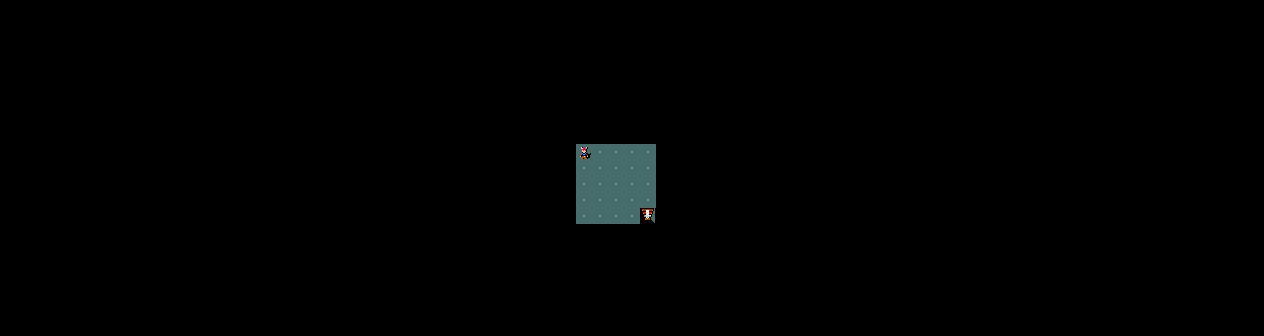

In [ ]:
# Create the environment with the observations keys required as input to the DQN
env = gym.make(
        id="MiniHack-Room-5x5-v0",
        max_episode_steps=100_000_000,
        observation_keys=("glyphs","pixel","message")
    )
# Reset the environment and display the screen of the starting state 
state = env.reset()
display_screen(state)

In [ ]:
# Train DQN on simple environment
test_scores, DQNagent_test = run_dqn(env,number_episodes=200,max_episode_length=2000,iterations=1)
# The results from a training iteration have been saved and the output of this cell is blank to keep the notebook clean
# Please run cell if you want to train your own model

In [ ]:
plot_results(env_name="Room-5x5-v0", scores=test_scores, color = "maroon")

NameError: ignored

In [ ]:
live_play_viz(env, DQNagent_test)

In [ ]:
env1 = MiniHackRoom15x15L1(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 

In [ ]:
# Also difficult to converge
L1_scores, DQNagent_L1 = run_dqn(env1,number_episodes=200,max_episode_length=2000,iterations=5)

## Expected-Sarsa

In [14]:
class ESarsa(Agent):

    def __init__(self, actions: List, alpha: float, gamma: float, eps: float):
        super().__init__()

        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

        self.q = {}
        self.sar = []

    def _action_value(self, state, action):
        """ Compute state-action value of this pair."""
        return self.q.get((state, action), 1e-3 * np.random.randn())

    def _get_action(self, state, eps):
        """ Return an eps-greedy action to be taken from this state.    """
        if np.random.rand() < eps:
            return np.random.choice(self.actions)
        action = max(self.actions, key=lambda action: self._action_value(state=state, action=action))
        return action

    def update(self, reward):
        """ Update state-action value of previous (state, action).
        Args:
            reward (float): Reward received upon the transaction to `state`.
        """
        self.sar[-1][-1] = reward
        if len(self.sar) < 2:
            return
        state = self.sar[1][0]
        action = self.sar[1][1]
        reward = self.sar[0][-1]
        prev_state = self.sar[0][0]
        prev_action = self.sar[0][1]

        # Compute the expected Q-value of the next state
        next_state = self.sar[-1][0]
        next_actions = [a for a in self.actions if (next_state, a) in self.q]
        if not next_actions:
            next_q = 0
        else:
            next_q = np.mean([self._action_value(next_state, a) for a in next_actions])

        # Compute the TD error and update the Q-value of the current state-action pair
        q = self._action_value(state=prev_state, action=prev_action)
        tmp = reward + self.gamma * next_q - q
        self.q[(prev_state, prev_action)] = q + self.alpha * tmp

        del self.sar[0]

    def take_action(self, state):
        """ Choose an eps-greedy action to be taken from this state. 
        Args:
            state (Any): The current state representation. It should be an immutable type since it's used as a key.
        """
        state = self.decode_state(state)
        action = self._get_action(state, self.eps)
        self.sar.append([state, action, 0])
        return action

    def end_episode(self):
        """ Update state-action value of the last (state, action) pair. 
        """
        prev_state = self.sar[0][0]
        prev_action = self.sar[0][1]
        
        q = self._action_value(state=prev_state, action=prev_action)

        self.q[(self.sar[0][0], self.sar[0][1])] = q + self.alpha * (self.sar[0][2] - q)
        
        self.sar = []

    def save(self, path: str):
        """ Save state-action value table in `path`.npy
        Args:
            path (str): The location of where to store the state-action value table.
        """
        super().save(path)
        np.save(path + '.npy', self.q)

    def load(self, path):
        """ Load state-action value table.
        If it doesn't exist, a randomly-initialized table is used.
        Args:
            path (str): The location of where the state-action value table resides.
        """

        try:
            self.q = np.load(path + '.npy', allow_pickle='TRUE').item()
        except:
            self.q = {}
            print("No file is found in:", path)

In [15]:
# Define the function to test q learning agent
def test_minihack_expectedsarsa(env,level):
    ALPHA = 0.1 # Learning rate
    GAMMA = 1 # discount
    EPS = 0.05 # exploration rate, the empirical value from the individual assignment
    ITERS = 200

    class MyAgent(ESarsa):
        def decode_state(self, state):
            return tuple(state['tty_cursor'])  

    esarsa = MyAgent(actions=list(range(env.action_space.n)),
                       alpha=ALPHA, gamma=GAMMA, eps=EPS)
    esarsa.load('esarsa_minihack'+level)

    all_rewards = []
    for i in range(ITERS):
        state = env.reset()
        # Get the target postision(Here we fixed it at the bottom right)
        n = 0
        done = False
        rewards = 0
        while not done:
            n += 1
            action = esarsa.take_action(state)
            state, reward, done, info = env.step(action)
            rewards+=reward
            esarsa.update(reward)

        esarsa.save('esarsa_minihack'+level)
        all_rewards.append(rewards)
        print('>'*40, f'Episode {i+1} is finished in {n} steps, the reward is {rewards}')

    return esarsa,all_rewards


In [16]:
env1 = MiniHackRoom15x15L1(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 
env2 = MiniHackRoom15x15L2(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 
env3 = MiniHackRoom20x20L3(observation_keys=('pixel', 'tty_cursor'),\
                           penalty_step = -0.1, penalty_time = -0.1, reward_lose=-10) 

In [24]:
esarsa_agent_L1, all_rewards_L1 = test_minihack_expectedsarsa(env1,"_L1")

No file is found in: esarsa_minihack_L1
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 1 is finished in 1205 steps, the reward is -609.9512474247435
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 2 is finished in 113 steps, the reward is -44.91709241782196
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 3 is finished in 121 steps, the reward is -38.57910261054391
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 4 is finished in 93 steps, the reward is -23.494520165093736
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 5 is finished in 102 steps, the reward is -43.36591227590473
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 6 is finished in 56 steps, the reward is -14.567174997773062
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 7 is finished in 72 steps, the reward is -23.219931358220062
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 8 is finished in 33 steps, the reward is 4.034284100169469
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 9 is finished in 43 steps, the r

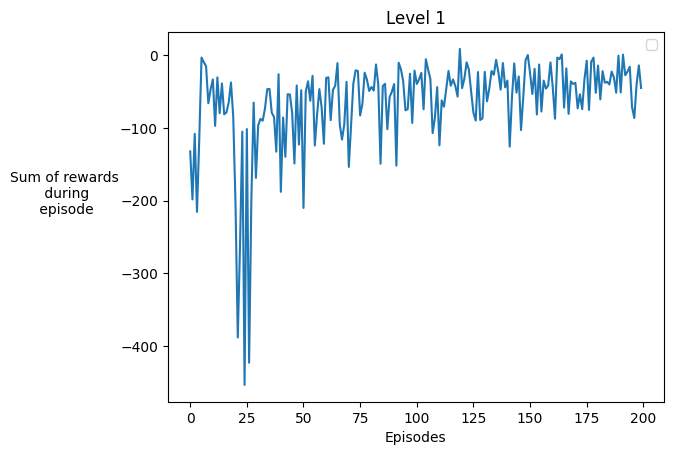

In [ ]:
plot_performance(all_rewards_L1,'1')

In [25]:
live_play_viz_es(env1, esarsa_agent_L1)

<Figure size 640x480 with 0 Axes>

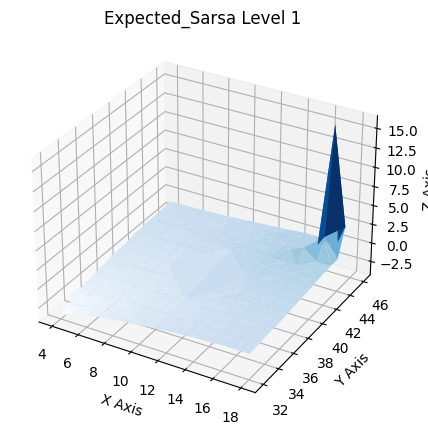

In [ ]:
plot_SVfunction(esarsa_agent_L1,"Expected_Sarsa Level 1")

In [17]:
esarsa_agent_L2, all_rewards_L2 = test_minihack_expectedsarsa(env2,"_L2")

No file is found in: esarsa_minihack_L2
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 1 is finished in 319 steps, the reward is -140.78251961669173
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 2 is finished in 625 steps, the reward is -381.29920717696046
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 3 is finished in 416 steps, the reward is -214.8737035115656
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 4 is finished in 435 steps, the reward is -181.51754609799647
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 5 is finished in 150 steps, the reward is -61.247741116335575
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 6 is finished in 157 steps, the reward is -57.935263042699845
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 7 is finished in 42 steps, the reward is -3.6927038627340387
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 8 is finished in 67 steps, the reward is -15.197938478748103
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 9 is finished in 158 steps

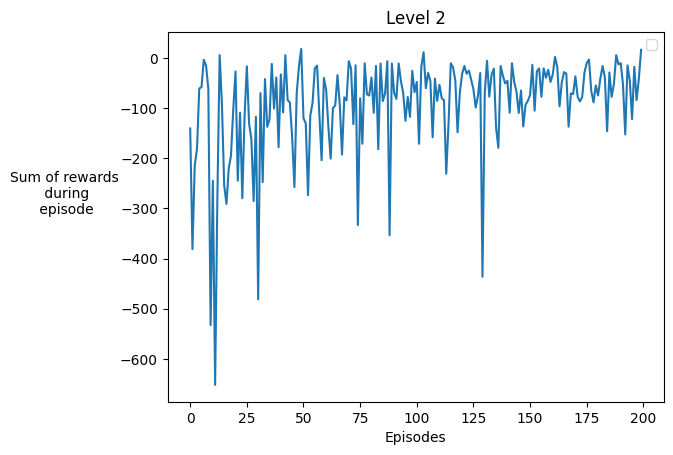

In [18]:
plot_performance(all_rewards_L2,'2')

In [23]:
live_play_viz_es(env2, esarsa_agent_L2)

<Figure size 640x480 with 0 Axes>

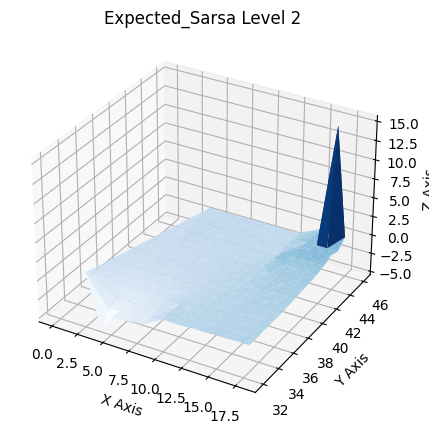

In [20]:
plot_SVfunction(esarsa_agent_L2,"Expected_Sarsa Level 2")

In [26]:
esarsa_agent_L3, all_rewards_L3 = test_minihack_expectedsarsa(env3,"_L3")

No file is found in: esarsa_minihack_L3
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 1 is finished in 160 steps, the reward is -36.839245122765576
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 2 is finished in 664 steps, the reward is -1067.5410293730358
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 3 is finished in 506 steps, the reward is -1114.3696465862417
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 4 is finished in 267 steps, the reward is -125.65405936458056
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 5 is finished in 130 steps, the reward is -335.5091303883983
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 6 is finished in 41 steps, the reward is -23.28231770849649
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 7 is finished in 107 steps, the reward is -30.41182021148921
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 8 is finished in 120 steps, the reward is -58.006925262748794
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Episode 9 is finished in 70 steps, 

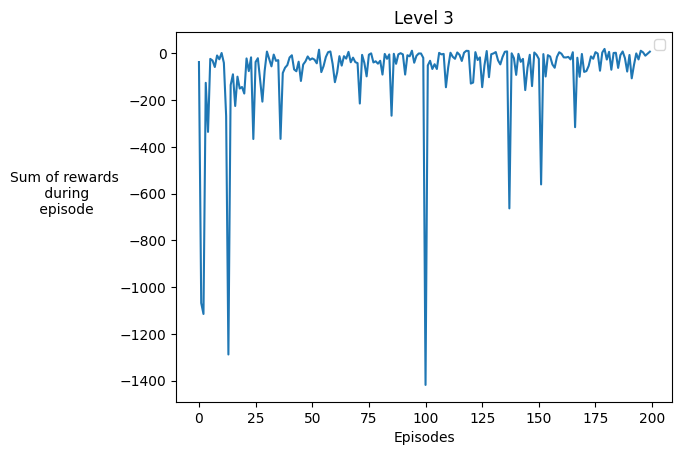

In [27]:
plot_performance(all_rewards_L3,'3')

In [30]:
live_play_viz_es(env3, esarsa_agent_L3)

<Figure size 640x480 with 0 Axes>

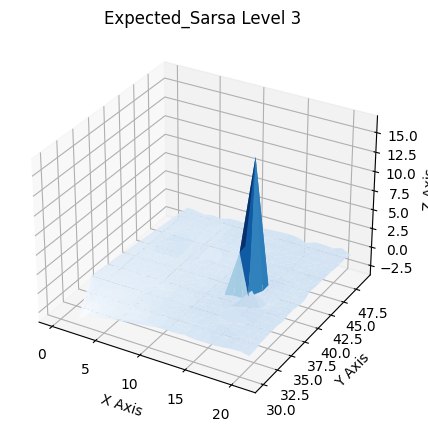

In [28]:
plot_SVfunction(esarsa_agent_L3,"Expected_Sarsa Level 3")

# Abandoned codes

In [ ]:
# Intuition: make the reward function denser, so that the agent can learn how to reach the target quicker.
def reward_check(state,target_pos):
    x,y = state
    x1,y1 = target_pos
    # For 15x15 map
    distance = np.sqrt((x-x1)**2+(y-y1)**2)
    max_distance = np.sqrt(15**2 + 15**2)
    # The closer the agent is with to the target, the larger the score
    # Add extra bonus when agent reach certain area closer enough to the target, so that the agent won't go back easily
    score = - distance/max_distance
    if distance <18:
        return score+0.025
    elif distance <15:
        return score+0.05
    elif distance <13:
        return score+0.075
    elif distance <10:
        return score+0.1
    elif distance <7:
        return score+0.15
    elif distance <5:
        return score+0.2
    elif distance <2:
        return score+0.3
    else:
        return score